## An Example In: Data Retreival and Storing
------

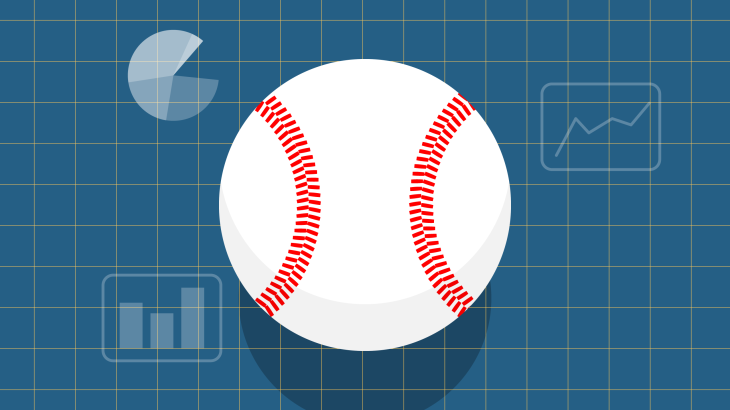

## *Table of Contents*
* [1. Introduction](#1)
* [2. Importing the Data](#2)  
* [3. Importing Data into SQLite](#3)
    * [3.1 Convert Columns to Numeric](#3.1)
    * [3.2 Parsing Geographic Coordinates for Schools](#3.2)
* [4. Combining the Data](#4)
    * [4.1 Condensing the Class Size Data Set](#4.1)
    * [4.2 Computing Average Class Sizes](#4.2)
    * [4.3 Condensing the Demographics Data Set](#4.3)
    * [4.4 Condensing the Graduation Data Set](#4.4)
    * [4.5 Converting AP Test Scores](#4.5)
    * [4.6 Performing the Left Joins](#4.6)
    * [4.7 Performing the Inner Joins](#4.7)
* [5. Filling in Missing Values](#5)
* [6. Testing the Dataset with Descriptive Statistics](#6)
    * [6.1 Exploring SAT-score and Survey Answer Correlations](#6.1)
    * [6.2 Exploring Races and SAT-Scores](#6.2)
    * [6.3 Explore Gender and SAT-Scores](#6.3)
* [7. Conclusion](#7)
* [8. Descriptive Statistics](#8)
-------------------------------------
<br>
<br>


## <a name="1"></a> 1. Introduction
Baseball is a great topic to practice skills in data science. Because of the long history within baseball of the collection and analysis of statistics (most famously [Sabermetrics](https://en.wikipedia.org/wiki/Sabermetrics) featured in the movie [Moneyball](https://en.wikipedia.org/wiki/Moneyball_%28film%29)), there is a massive potential of answering a pletheora of questions regarding baseball.

#### Note on the data
We will be working with a file of [Major League Baseball](https://en.wikipedia.org/wiki/Major_League_Baseball) games from [Retrosheet](https://www.retrosheet.org/gamelogs/index.html). Retrosheet compiles detailed statistics on baseball games from the 1800s through today. With such a massive amount of data, it will be an ideal project to design and create a relational database which could store and retreive these data efficiently.

#### CSV files in this projects:
* `game_log.csv` has been produced by combining 127 CSV files from retrosheet (pre-cleaned)
* `park_codes.csv` list of ballpark IDs and addresses
* `person_codes.csv` list of baseball player IDs and names
* `team_codes.csv` list of team IDs and associated leagues
* `game_log_fields.csv` a helper file which will only function as a lookup guidance.

<br>

#### The gloal of this project:
* Utilize ***SQLite*** as our databse
* Execute SQL in python library ***sqlite3***
* Design a ***normalized*** database schema
* Create tables for our schema
* Insert data into our schema

Let's start by running the `game_log_fields.txt` to create a lookup reference in this notebook for the fields in the game_log data.

In [16]:
f = open('Data/database/game_log_fields.txt','r')
game_log_fields = f.read()
print(game_log_fields)
f.close()

Field(s)  Meaning
    1     Date in the form "yyyymmdd"
    2     Number of game:
             "0" -- a single game
             "1" -- the first game of a double (or triple) header
                    including seperate admission doubleheaders
             "2" -- the second game of a double (or triple) header
                    including seperate admission doubleheaders
             "3" -- the third game of a triple-header
             "A" -- the first game of a double-header involving 3 teams
             "B" -- the second game of a double-header involving 3 teams
    3     Day of week  ("Sun","Mon","Tue","Wed","Thu","Fri","Sat")
  4-5     Visiting team and league
    6     Visiting team game number
          For this and the home team game number, ties are counted as
          games and suspended games are counted from the starting
          rather than the ending date.
  7-8     Home team and league
    9     Home team game number
10-11     Visiting and home team score (unquoted)


## <a name="2"></a> 2. Importing the Data
Now we have an overview of the columns in the `game_log`, the next step will be to import the data. Due to the shear amount of data in the `game_log` we will ned to set some max options when using the pandas to import the data. Otherwise we will risk our output being truncated.

In [2]:
import pandas as pd
pd.set_option('max_columns', 180)
pd.set_option('max_rows', 200000)
pd.set_option('max_colwidth', 5000)

game_log = pd.read_csv('Data/database/game_log.csv', low_memory=False) # low_memory allows more memory usage for dtyping
game_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171907 entries, 0 to 171906
Columns: 161 entries, date to acquisition_info
dtypes: float64(77), int64(6), object(78)
memory usage: 211.2+ MB


In [3]:
game_log.head() #Displays the first 5 rows of the dataframe

,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,h_score,length_outs,day_night,completion,forefeit,protest,park_id,attendance,length_minutes,v_line_score,h_line_score,v_at_bats,v_hits,v_doubles,v_triples,v_homeruns,v_rbi,v_sacrifice_hits,v_sacrifice_flies,v_hit_by_pitch,v_walks,v_intentional_walks,v_strikeouts,v_stolen_bases,v_caught_stealing,v_grounded_into_double,v_first_catcher_interference,v_left_on_base,v_pitchers_used,v_individual_earned_runs,v_team_earned_runs,v_wild_pitches,v_balks,v_putouts,v_assists,v_errors,v_passed_balls,v_double_plays,v_triple_plays,h_at_bats,h_hits,h_doubles,h_triples,h_homeruns,h_rbi,h_sacrifice_hits,h_sacrifice_flies,h_hit_by_pitch,h_walks,h_intentional_walks,h_strikeouts,h_stolen_bases,h_caught_stealing,h_grounded_into_double,h_first_catcher_interference,h_left_on_base,h_pitchers_used,h_individual_earned_runs,h_team_earned_runs,h_wild_pitches,h_balks,h_putouts,h_assists,h_errors,h_passed_balls,h_double_plays,h_triple_plays,hp_umpire_id,hp_umpire_name,1b_umpire_id,1b_umpire_name,2b_umpire_id,2b_umpire_name,3b_umpire_id,3b_umpire_name,lf_umpire_id,lf_umpire_name,rf_umpire_id,rf_umpire_name,v_manager_id,v_manager_name,h_manager_id,h_manager_name,winning_pitcher_id,winning_pitcher_name,losing_pitcher_id,losing_pitcher_name,saving_pitcher_id,saving_pitcher_name,winning_rbi_batter_id,winning_rbi_batter_id_name,v_starting_pitcher_id,v_starting_pitcher_name,h_starting_pitcher_id,h_starting_pitcher_name,v_player_1_id,v_player_1_name,v_player_1_def_pos,v_player_2_id,v_player_2_name,v_player_2_def_pos,v_player_3_id,v_player_3_name,v_player_3_def_pos,v_player_4_id,v_player_4_name,v_player_4_def_pos,v_player_5_id,v_player_5_name,v_player_5_def_pos,v_player_6_id,v_player_6_name,v_player_6_def_pos,v_player_7_id,v_player_7_name,v_player_7_def_pos,v_player_8_id,v_player_8_name,v_player_8_def_pos,v_player_9_id,v_player_9_name,v_player_9_def_pos,h_player_1_id,h_player_1_name,h_player_1_def_pos,h_player_2_id,h_player_2_name,h_player_2_def_pos,h_player_3_id,h_player_3_name,h_player_3_def_pos,h_player_4_id,h_player_4_name,h_player_4_def_pos,h_player_5_id,h_player_5_name,h_player_5_def_pos,h_player_6_id,h_player_6_name,h_player_6_def_pos,h_player_7_id,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,18710504,0,Thu,CL1,NaN,1,FW1,NaN,1,0,2,54.0,D,NaN,NaN,NaN,FOR01,200.0,120.0,000000000,010010000,30.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,6.0,1.0,NaN,-1.0,NaN,4.0,1.0,1.0,1.0,0.0,0.0,27.0,9.0,0.0,3.0,0.0,0.0,31.0,4.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,NaN,-1.0,NaN,3.0,1.0,0.0,0.0,0.0,0.0,27.0,3.0,3.0,1.0,1.0,0.0,boakj901,John Boake,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,paboc101,Charlie Pabor,lennb101,Bill Lennon,mathb101,Bobby Mathews,prata101,Al Pratt,NaN,NaN,NaN,NaN,prata101,Al Pratt,mathb101,Bobby Mathews,whitd102,Deacon White,2.0,kimbg101,Gene Kimball,4.0,paboc101,Charlie Pabor,7.0,allia101,Art Allison,8.0,white104,Elmer White,9.0,prata101,Al Pratt,1.0,sutte101,Ezra Sutton,5.0,carlj102,Jim Carleton,3.0,bassj101,John Bass,6.0,selmf101,Frank Sellman,5.0,mathb101,Bobby Mathews,1.0,foraj101,Jim Foran,3.0,goldw101,Wally Goldsmith,6.0,lennb101,Bill Lennon,2.0,caret101,Tom Carey,4.0,mince101,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,18710505,0,Fri,BS1,NaN,1,WS3,NaN,1,20,18,54.0,D,NaN,NaN,NaN,WAS01,5000.0,145.0,107000435,640113030,41.0,13.0,1.0,2.0,0.0,13.0,0.0,0.0,0.0,18.0,NaN,5.0,3.0,NaN,-1.0,NaN,12.0,1.0,6.0,6.0,1.0,0.0,27.0,13.0,10.0,1.0,2.0,0.0,49.0,14.0,2.0,0.0,0.0,11.0,0.0,0.0,0.0,10.0,NaN,2.0,1.0,NaN,-1.0,NaN,14.0,1.0,7.0,7.0,0.0,0.0,27.0,20.0,10.0,2.0,3.0,0.0,dobsh901,Henry Dobson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wrigh101,Harry Wright,younn801,Nick Young,spala101,Al Spalding,braia102,Asa Brainard,NaN,NaN,NaN,NaN,spala101,Al Spalding,braia102,Asa Brainard,wrigg101,George Wright,6.0,barnr102,Ross

The `info()` confirms the impressive size of the txt file, with ***161 columns*** and ***171907 rows***. Remember we can refer to the `game_log_fields` for any clarification of the column names.

Let's import the remaining 3 CSV files.

In [4]:
park_codes = pd.read_csv('Data/database/park_codes.csv')
person_codes = pd.read_csv('Data/database/person_codes.csv')
team_codes = pd.read_csv('Data/database/team_codes.csv')
park_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 9 columns):
PARKID    252 non-null object
NAME      252 non-null object
AKA       56 non-null object
CITY      252 non-null object
STATE     252 non-null object
START     252 non-null object
END       222 non-null object
LEAGUE    187 non-null object
NOTES     128 non-null object
dtypes: object(9)
memory usage: 17.8+ KB


In [5]:
park_codes.head()

,PARKID,NAME,AKA,CITY,STATE,START,END,LEAGUE,NOTES
0,ALB01,Riverside Park,NaN,Albany,NY,09/11/1880,05/30/1882,NL,TRN:9/11/80;6/15&9/10/1881;5/16-5/18&5/30/1882
1,ALT01,Columbia Park,NaN,Altoona,PA,04/30/1884,05/31/1884,UA,NaN
2,ANA01,Angel Stadium of Anaheim,Edison Field; Anaheim Stadium,Anaheim,CA,4/19/1966,NaN,AL,NaN
3,ARL01,Arlington Stadium,NaN,Arlington,TX,4/21/1972,10/3/1993,AL,NaN
4,ARL02,Rangers Ballpark in Arlington,The Ballpark in Arlington; Ameriquest Fl,Arlington,TX,4/11/1994,NaN,AL,NaN


In [28]:
person_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20493 entries, 0 to 20492
Data columns (total 7 columns):
ID              20493 non-null object
Last            20493 non-null object
First           20433 non-null object
Player debut    19183 non-null object
Mgr debut       701 non-null object
Coach debut     1566 non-null object
Ump debut       1546 non-null object
dtypes: object(7)
memory usage: 1.1+ MB


In [29]:
person_codes.head()

,ID,Last,First,Player debut,Mgr debut,Coach debut,Ump debut
0,aardd001,Aardsma,David,4/6/2004,NaN,NaN,NaN
1,aaroh101,Aaron,Hank,4/13/1954,NaN,NaN,NaN
2,aarot101,Aaron,Tommie,4/10/1962,NaN,4/6/1979,NaN
3,aased001,Aase,Don,7/26/1977,NaN,NaN,NaN
4,abada001,Abad,Andy,9/10/2001,NaN,NaN,NaN


In [30]:
team_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
team_id      150 non-null object
league       124 non-null object
start        150 non-null int64
end          150 non-null int64
city         150 non-null object
nickname     150 non-null object
franch_id    150 non-null object
seq          150 non-null int64
dtypes: int64(3), object(5)
memory usage: 9.5+ KB


In [31]:
team_codes.head()

,team_id,league,start,end,city,nickname,franch_id,seq
0,ALT,UA,1884,1884,Altoona,Mountain Cities,ALT,1
1,ARI,NL,1998,0,Arizona,Diamondbacks,ARI,1
2,BFN,NL,1879,1885,Buffalo,Bisons,BFN,1
3,BFP,PL,1890,1890,Buffalo,Bisons,BFP,1
4,BL1,NaN,1872,1874,Baltimore,Canaries,BL1,1


Now that we have imported the last 3 CSV files, we can observe that the largest of these 3 are not surpringly the `person_codes`. Most the the column names are intuitive to decipher, yet a few columns might require a minor clarification, such as the `league` column.

The column `league` is located in he `team_codes`, `park_codes` and `game_log` dataframes. It is important to know what each value represents:
* `NA` = National Association
* `NL` = National League
* `AA` = American Association
* `UA` = Union Association
* `PL` = Players League
* `AA` = American League
* `FL` = Federal League

The `def_pos` columns in the `game_log` dataframe is filled with numbers from **1-9**, which is not very telling. These numbers represent different defensive positions in baseball. The image below illustrates the positions:
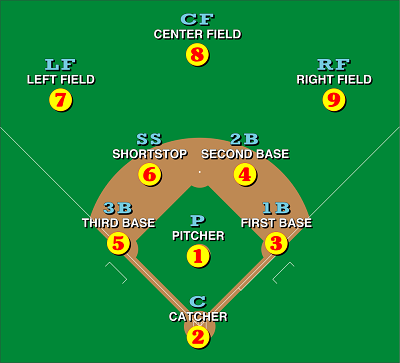

<br>

## <a name="3"></a> 3. Importing Data into SQLite
To insert data into a ***normalized database***, we'll need a single column that can be used as a `primary key`. The game log file does not have a single column that can be used as a primary key to uniquely identify each game. Fortunately, if we explore the Retrosheet site, we can find this [data dictionary](https://www.retrosheet.org/eventfile.htm) for their event files, which list every event within each game. This includes the following description:

> **id:** Each game begins with a twelve character ID record which identifies the date, home team, and number of the game. For example, `ATL198304080` should be read as follows. The **first three** characters identify the home team (the Braves). The **next four** are the year (1983). The **next two** are the month (April) using the standard numeric notation, 04, **followed by the day** (08). The **last digit** indicates if this is a single game (0), first game (1) or second game (2) if more than one game is played during a day, usually a double header The id record starts the description of a game thus ending the description of the preceding game in the file.

Now that we know how to assemble the primary key, we will first import the dataframes into individual temporary tables in the SQLite database. Hereafter, we will create a primary key column in the game_log table.

We will handle all data transfers by using `sqlite3` and `DataFrame.to_sql()`. In this quest we will create 2 functions which will become very convinient. The first funciton will be `run_query` which will be used for retreiving data from the SQLite database. The second function will be `run_command` which will be used to run SQL that only modify the database itself.

In [6]:
import sqlite3
import matplotlib
%matplotlib inline

def run_query(q):
    with sqlite3.connect('Data/database/mlb.db') as conn:
        return pd.read_sql(q, conn)

def run_command(q):
    with sqlite3.connect('Data/database/mlb.db') as conn:
        conn.isolation_level = None
        conn.execute(q)
        return

The 2 functions are now ready to make our life easier. The next step is to transfer all our data from the dataframes to the  SQLite database by using `DataFrame.to_sql()`. Since no SQLite database exists at this time, the `DataFrame.to_sql()` will automatically create one for us. 

In [7]:
conn = sqlite3.connect('Data/database/mlb.db')
team_codes.to_sql('team_codes', conn, index=False) # the index=False will ensure no index column will be created
park_codes.to_sql('park_codes', conn, index=False)
person_codes.to_sql('person_codes', conn, index=False)
game_log.to_sql('game_log', conn, index=False)
conn.close() # closes the connection with the SQLite database

C:\Users\Jcbso\Anaconda3\lib\site-packages\pandas\core\generic.py:2130: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype)


Our SQLite database now have 4 tables with data. To wrap this section up, we will add a column to the `game_log` table which will contain the ***unique ID*** we previously discovered in the data dictionary. We will perform this task with the `run_command` function to carry out the `SQL` commands.

In [17]:
#q = 'ALTER TABLE game_log ADD COLUMN game_id' # Creates the 'game_id' column
#run_command(q)
q = 'UPDATE game_log SET game_id = h_name||date||number_of_game' # updates the 'game_id' column with the primary key value
run_command(q)

In [18]:
q = 'SELECT game_id FROM game_log LIMIT 10'
run_query(q)

,game_id
0,FW1187105040
1,WS3187105050
2,RC1187105060
3,CH1187105080
4,TRO187105090
5,CL1187105110
6,CL1187105130
7,FW1187105130
8,FW1187105150
9,BS1187105160


In [32]:
q = '''
CREATE TABLE league (
    league_id VARCHAR(255) PRIMARY KEY,
    name VARCHAR(255)
)
'''
run_command(q)

In [37]:
q = '''
INSERT INTO league
VALUES
    ("NL", "National League"),
    ("AA", "American Ass"),
    ("UA", "United Ass"),
    ("PL", "Pioneer League"),
    ("AL", "American League")
'''
run_command(q)